# Exercise 7: Matching

**Summer Semester 2025**

**Author**: Stefan Baumann (stefan.baumann@lmu.de)

## Instructions

Parts where code should be added are marked using `TODO Student` and `END Student`. Add your code between these markers but leave them in the code. There should be no need to change code outside of these spans besides imports. Similarly, space for answering the three free-text questions is provided in the markdown and also marked by `TODO Student`.

*Please* add extensive comments to your code to explain what you're doing/trying to do. It is hard to assign partial points for incorrect or incomplete solutions if we do not understand what you are trying to do.

For the third part of this exercise, we recommend using a GPU, although it is not required. We verified that the exercise can be solved on Nvidia GPUs, Apple Silicon GPUs (an M3 Pro can run the whole reference solution in ~5s), and CPU-only setups.

In [ ]:
import math

import numpy as np
import torch
import torch.nn.functional as F
from torchvision.io import read_video
from torchvision.utils import flow_to_image
from einops import rearrange
from skimage.feature import plot_matched_features, SIFT, match_descriptors
from skimage.transform import warp
from skimage.io import imread
from skimage.color import rgb2gray
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device "{device}".')

Using device "mps".


## Task 1: Image Matching

### SIFT & Matching

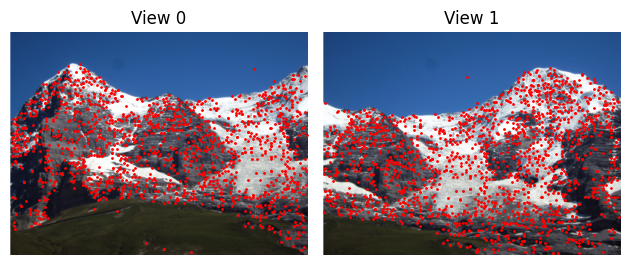

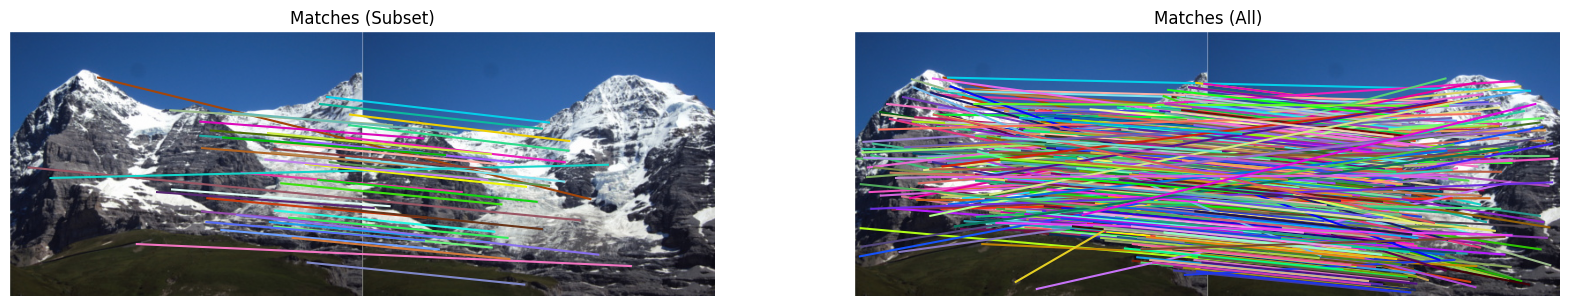

In [2]:
# TODO Student: Load images and extract features using SIFT
# Variables to use: view0, view1 (both shape H W C), keypoints0, keypoints1 (both shape N 2)

view0 = imread("data/view0.jpg")
view1 = imread("data/view1.jpg")

sift = SIFT()
sift.detect_and_extract(rgb2gray(view0))
keypoints0 = sift.keypoints
descriptors0 = sift.descriptors
sift.detect_and_extract(rgb2gray(view1))
keypoints1 = sift.keypoints
descriptors1 = sift.descriptors

# END Student

plt.subplot(1, 2, 1)
plt.title("View 0")
plt.imshow(view0)
plt.scatter(keypoints0[:, 1], keypoints0[:, 0], color="red", s=1)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("View 1")
plt.imshow(view1)
plt.scatter(keypoints1[:, 1], keypoints1[:, 0], color="red", s=1)
plt.axis("off")

plt.tight_layout()
plt.show()

# TODO Student: Detect matches
# Variables to use: matches (shape M 2)
matches = match_descriptors(descriptors0, descriptors1)
# END Student

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title("Matches (Subset)")
plot_matched_features(
    view0,
    view1,
    keypoints0=keypoints0,
    keypoints1=keypoints1,
    matches=matches[::20],
    ax=plt.gca(),
    only_matches=True,
)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Matches (All)")
plot_matched_features(
    view0,
    view1,
    keypoints0=keypoints0,
    keypoints1=keypoints1,
    matches=matches,
    ax=plt.gca(),
    only_matches=True,
)
plt.axis("off")
plt.show()

To fit an affine transformation to the matched keypoints we need to convert our problem into a linear equation system.
The general format of an affine transformation
$$
	\begin{pmatrix}
		x_t\\
		y_t
	\end{pmatrix}=
	\begin{pmatrix}
		s_{11} & s_{12}\\
		s_{21} & s_{22}
	\end{pmatrix}\cdot
	\begin{pmatrix}
		x_s\\
		y_s
	\end{pmatrix}+
	\begin{pmatrix}
		t_1\\
		t_2
	\end{pmatrix}
	=\mathbf{A}{\mathbf{x}_s}+{\mathbf{t}}
$$
can be represented as the following format:
$$
\begin{pmatrix}
 & & \dotsm\\
x_{i,s} & y_{i,s} & 1 & 0 & 0 & 0\\
0 & 0 & 0 & x_{i,s} & y_{i,s} & 1\\
& & \dotsm
\end{pmatrix}
\cdot
\begin{pmatrix}
s_{11}\\
s_{12}\\
t_1\\
s_{21}\\
s_{22}\\
t_2
\end{pmatrix}
= 
\begin{pmatrix}
\dotsm\\
x_{i,t}\\
y_{i,t}\\
\dotsm
\end{pmatrix}
$$

To solve the system $\mathbf{A}\mathbf{x}=\mathbf{b}$ for $\mathbf{x}$, we can use the Moore-Penrose pseudo-inverse $\mathbf{A}^\dagger$ of $\mathbf{A}$ to obtain the least-squares solution. For our solution then holds
$$
\mathbf{x}=\mathbf{A}^\dagger\cdot\mathbf{b}=\left(\mathbf{A}^\intercal\mathbf{A}\right)^{-1}\mathbf{A}^\intercal\mathbf{b}
$$

## Affine Solving

In [3]:
def solve_affine(source_points, target_points):
    """Solve the affine transformation matrix from source to target points.

    Args:
        source_points (np.ndarray): shape (N, 2)
        target_points (np.ndarray): shape (N, 2)

    Returns:
        np.ndarray: affine transform as homogeneous matrix of shape (3, 3)
        (top left 2x2 contains the scale matrix, top right 2x1 contains the translation vector, bottom row is [0, 0, 1])
    """
    assert len(source_points) == len(target_points), "Source and target points should have the same cardinality"
    N = len(source_points)

    # TODO Student
    A = np.zeros((2 * N, 6))
    b = np.zeros((2 * N, 1))

    for i in range(N):
        x, y = source_points[i]
        u, v = target_points[i]
        A[2 * i] = [x, y, 1, 0, 0, 0]
        A[2 * i + 1] = [0, 0, 0, x, y, 1]
        b[2 * i] = u
        b[2 * i + 1] = v
    
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    return np.array([[x[0, 0], x[1, 0], x[2, 0]], [x[3, 0], x[4, 0], x[5, 0]], [0, 0, 1]])
    # END Student


def transform_affine(points, mat):
    """Transform points using an affine transformation matrix.

    Args:
        points (np.ndarray): shape (N, 2)
        mat (np.ndarray): affine transform as homogeneous matrix of shape (3, 3)

    Returns:
        np.ndarray: transformed points of shape (N, 2)
    """
    return np.einsum("ij,nj->ni", mat[:2], np.concatenate([points, np.ones((len(points), 1))], axis=-1))


# Unit Test: use a known transformation matrix to warp points and then solve for the matrix again
# DO NOT CHANGE!
# In case of a partial solution, the test will fail, but do not disable it.
test_mat = np.array([[0.5, 0.5, 1.0], [0.5, 0.5, 1.0], [0.0, 0.0, 1.0]])
test_source = np.array([[0.0, -1.0], [0.2, -0.3], [1.0, 1.7]])

test_mat_pred = solve_affine(test_source, transform_affine(test_source, test_mat))
assert np.allclose(test_mat, test_mat_pred), "The predicted transformation matrix does not match the original."
print("Unit test passed.")

Unit test passed.


## Visualization

Estimated affine transformation matrix: [[ 7.90586201e-01  3.26206616e-02  4.71538930e+01]
 [-1.44224397e-02  2.06600175e-02  1.59220155e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


/Users/stefanbaumann/miniconda3/envs/python3.10/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


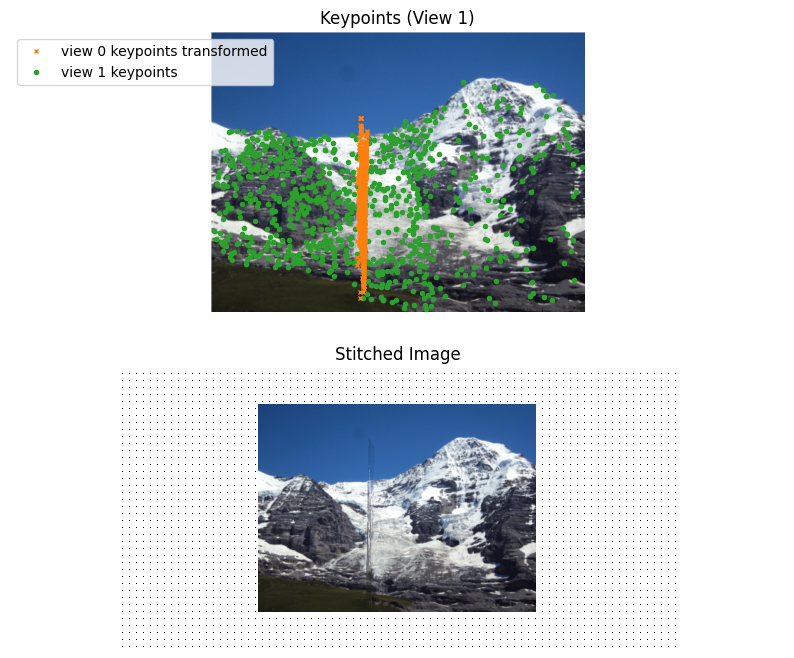

In [4]:
source_matched = keypoints0[matches[:, 0]]
target_matched = keypoints1[matches[:, 1]]

affine_mat = solve_affine(source_matched, target_matched)
print("Estimated affine transformation matrix:", affine_mat)

# Transform source points to target points
transformed = transform_affine(source_matched, affine_mat)


# Plot the results
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Keypoints (View 1)")
plt.imshow(view1)
plt.plot(
    transformed[:, 1],
    transformed[:, 0],
    marker="x",
    markersize=3,
    linewidth=0,
    c="C1",
    label="view 0 keypoints transformed",
    zorder=10,
)
plt.plot(
    target_matched[:, 1],
    target_matched[:, 0],
    marker="o",
    markersize=3,
    linewidth=0,
    c="C2",
    label="view 1 keypoints",
)
plt.legend()
plt.axis("equal")
plt.axis("off")

plt.subplot(2, 1, 2)
plt.title("Stitched Image")
padx = 200
pady = 50
out_shape = (view1.shape[0] + 2 * pady, view1.shape[1] + 2 * padx)
# Compute transform for warping
# Warping uses a different coordinate convention, so we convert first, also accounting for padding
hmat = np.array(
    [
        [affine_mat[1, 1], affine_mat[1, 0], affine_mat[1, 2]],
        [affine_mat[0, 1], affine_mat[0, 0], affine_mat[0, 2]],
        [0.0, 0.0, 1.0],
    ]
)
glob_mat = np.array([[1.0, 0.0, padx], [0.0, 1.0, pady], [0.0, 0.0, 1.0]])
warp_mat = np.linalg.inv(glob_mat @ hmat)
# Warp the first image and stitch it with the second image
warped = warp(view0, warp_mat, output_shape=out_shape, cval=np.inf)
warp_valid = np.isfinite(warped[pady:-pady, padx:-padx])
warped[pady:-pady, padx:-padx][~warp_valid] = (view1 / 255)[~warp_valid]
warped[pady:-pady, padx:-padx][warp_valid] = (warped[pady:-pady, padx:-padx] / 2 + view1 / 510)[warp_valid]
plt.imshow(warped)
plt.axis("off")

plt.show()

---
**Describe what you see. Does the transformation look good?**

Due to the presence of outlier matches (see first match visualization), brute force matching on all poitns leads to a broken prediction - in this case, a collapsed transformation.

---

## Task 2: Robust Affine Transformation with RANSAC

RANSAC Iterations: 100%|██████████| 18/18 [00:00<00:00, 2907.89it/s]


Estimated transformation matrix: [[ 9.77579721e-01  5.35264167e-02  1.07712194e+01]
 [-3.72582544e-02  9.76087878e-01 -1.37263143e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


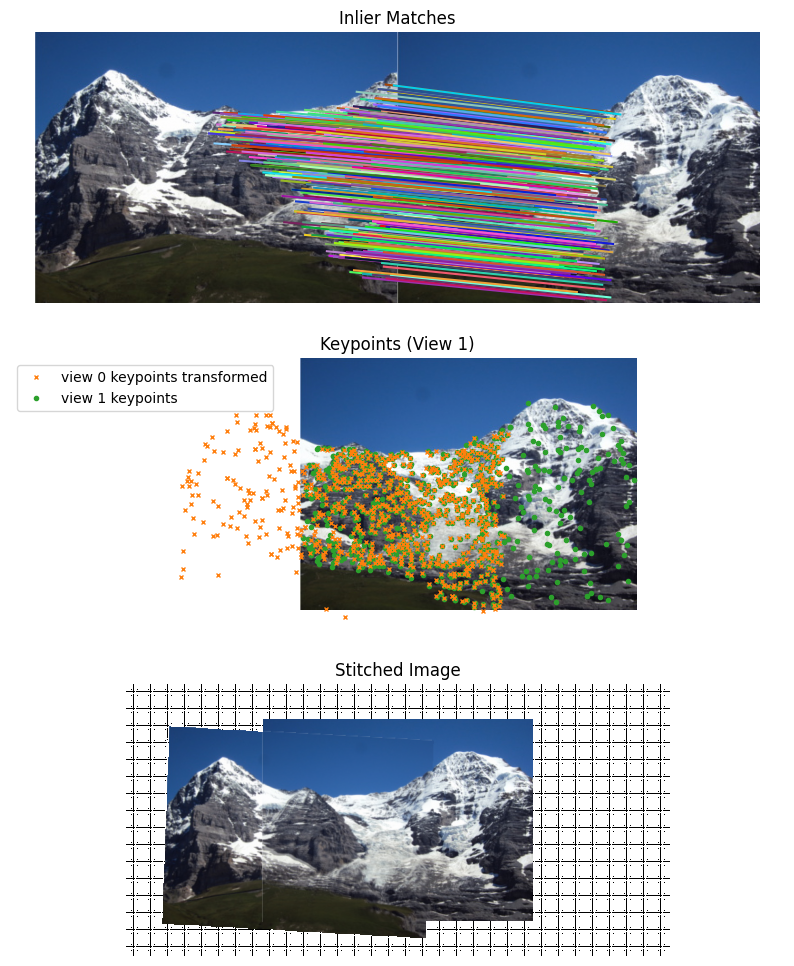

In [5]:
class RANSAC:
    def __init__(
        self,
        inlier_probability: float = 0.99,
        outlier_ratio: float = 0.1,
        max_iterations: int = 1e4,
        threshold: float = 1.0,
        min_consensus_size: int = 100,
    ):
        self.inlier_probability = inlier_probability
        self.outlier_ratio = outlier_ratio
        self.min_points_required = 3
        self.max_iterations = max_iterations
        self.threshold = threshold
        self.min_consensus_size = min_consensus_size

        self.best_mat = None
        self.inlier_indices = None

    def find_inliers(self, source_points, target_points, mat):
        """Find inliers based on the current transformation matrix.

        Args:
            source_points (np.ndarray): shape (N, 2)
            target_points (np.ndarray): shape (N, 2)
            mat (np.ndarray): affine transform as homogeneous matrix of shape (3, 3)

        Returns:
            tuple: (transformation matrix (np.ndarray, shape (3, 3)), inlier indices (np.ndarray, shape (M,)))
        """
        assert len(source_points) == len(target_points), "Source and target points should have the same cardinality"

        # TODO Student
        inlier_indices = np.where(
            np.linalg.norm(transform_affine(source_points, mat) - target_points, axis=1) < self.threshold
        )[0]
        # Refit if inlier set sufficiently large
        if len(inlier_indices) > self.min_consensus_size:
            mat = solve_affine(
                source_points[inlier_indices],
                target_points[inlier_indices],
            )
        return mat, inlier_indices

        # END Student

    def fit(self, source_points, target_points):
        """Fit an affine transformation using RANSAC.

        Args:
            source_points (np.ndarray): shape (N, 2)
            target_points (np.ndarray): shape (N, 2)

        Returns:
            tuple: (best transformation matrix (np.ndarray, shape (3, 3)), inlier indices (np.ndarray, shape (M,)))
        """
        assert len(source_points) > self.min_points_required, "Not enough points to fit an affine transformation"
        assert len(source_points) == len(target_points), "Source and target points should have the same cardinality"

        # TODO Student
        N, _ = source_points.shape
        self.max_inliers = 0
        self.best_mat = None

        num_iterations = int(
            math.log(1 - self.inlier_probability) / math.log(1 - (1 - self.outlier_ratio) ** self.min_points_required)
        )
        num_iterations = min(num_iterations, self.max_iterations)

        for _ in tqdm(range(num_iterations), desc="RANSAC Iterations"):
            indices = np.random.choice(N, self.min_points_required, replace=False)
            sample_source = source_points[indices]
            sample_target = target_points[indices]

            mat = solve_affine(sample_source, sample_target)

            refined_mat, inlier_indices = self.find_inliers(source_points, target_points, mat)
            if len(inlier_indices) > self.max_inliers:
                self.max_inliers = len(inlier_indices)
                self.best_mat = refined_mat
                self.inlier_indices = inlier_indices
        return self.best_mat, self.inlier_indices
        # END Student


source_matched = keypoints0[matches[:, 0]]
target_matched = keypoints1[matches[:, 1]]

# Fit affine transformation with RANSAC
# These parameters should lead to a good match for the given images, there should be no need to change them.
ransac = RANSAC(
    inlier_probability=0.99,
    outlier_ratio=0.4,
    threshold=2.0,
    min_consensus_size=10,
)
best_mat, inlier_indices = ransac.fit(source_matched, target_matched)
print("Estimated transformation matrix:", best_mat)

# Transform points
transformed = transform_affine(source_matched, best_mat)


# Plot the results
plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.title("Inlier Matches")
m = np.concatenate([inlier_indices.reshape(-1, 1)] * 2, axis=-1)
plot_matched_features(
    view0,
    view1,
    keypoints0=source_matched,
    keypoints1=target_matched,
    matches=m,
    ax=plt.gca(),
    only_matches=True,
)
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("Keypoints (View 1)")
plt.imshow(view1)
plt.plot(
    transformed[:, 1],
    transformed[:, 0],
    marker="x",
    markersize=3,
    linewidth=0,
    c="C1",
    label="view 0 keypoints transformed",
    zorder=10,
)
plt.plot(
    target_matched[:, 1],
    target_matched[:, 0],
    marker="o",
    markersize=3,
    linewidth=0,
    c="C2",
    label="view 1 keypoints",
)
plt.legend()
plt.axis("equal")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("Stitched Image")
padx = 200
pady = 50
out_shape = (view1.shape[0] + 2 * pady, view1.shape[1] + 2 * padx)
# Compute transform for warping
# Warping uses a different coordinate convention, so we convert first, also accounting for padding
hmat = np.array(
    [
        [best_mat[1, 1], best_mat[1, 0], best_mat[1, 2]],
        [best_mat[0, 1], best_mat[0, 0], best_mat[0, 2]],
        [0.0, 0.0, 1.0],
    ]
)
glob_mat = np.array([[1.0, 0.0, padx], [0.0, 1.0, pady], [0.0, 0.0, 1.0]])
warp_mat = np.linalg.inv(glob_mat @ hmat)
# Warp the first image and stitch it with the second image
warped = warp(view0, warp_mat, output_shape=out_shape, cval=np.inf)
warp_valid = np.isfinite(warped[pady:-pady, padx:-padx])
warped[pady:-pady, padx:-padx][~warp_valid] = (view1 / 255)[~warp_valid]
warped[pady:-pady, padx:-padx][warp_valid] = (warped[pady:-pady, padx:-padx] / 2 + view1 / 510)[warp_valid]
plt.imshow(warped)
plt.axis("off")

plt.show()

---
**Compare these results to the previous ones. What has changed, and why?**

Now, we find a set of matches that lead to a self-consistent, robust estimate of the transform, ignoring outliers. This significantly improves the results. The transform overall is still not perfect, as it still assumes that an affine transform is sufficient for this operation (a perspective transform would be more accurate, but even that will ignore many aspects of the camera's projection; for any great results, we'd also need a robust depth estimate), but it's now generally accurate enough for a decent result.

---

## Task 3: Optical Flow-Based Image Warping

In [6]:
# Load video and convert to torch tensor
device = "cuda" if torch.cuda.is_available() else "cpu" # MPS doesn't do bilinear interpolation on older torch versions
seq, _, _ = read_video("data/video.mp4", pts_unit="sec")
seq = (seq / 255.0 - 0.5) / 0.5  # map to [-1, 1]
seq = rearrange(seq, "t h w c -> t c h w").to(device)
seq = F.interpolate(seq, (256, 256), mode="bilinear", antialias=True) # (t, c, h, w)

In [7]:
# TODO Student: Load RAFT model
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights

raft = raft_large(Raft_Large_Weights.DEFAULT).to(device)
raft = raft.eval()
# END Student

/Users/stefanbaumann/miniconda3/envs/python3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


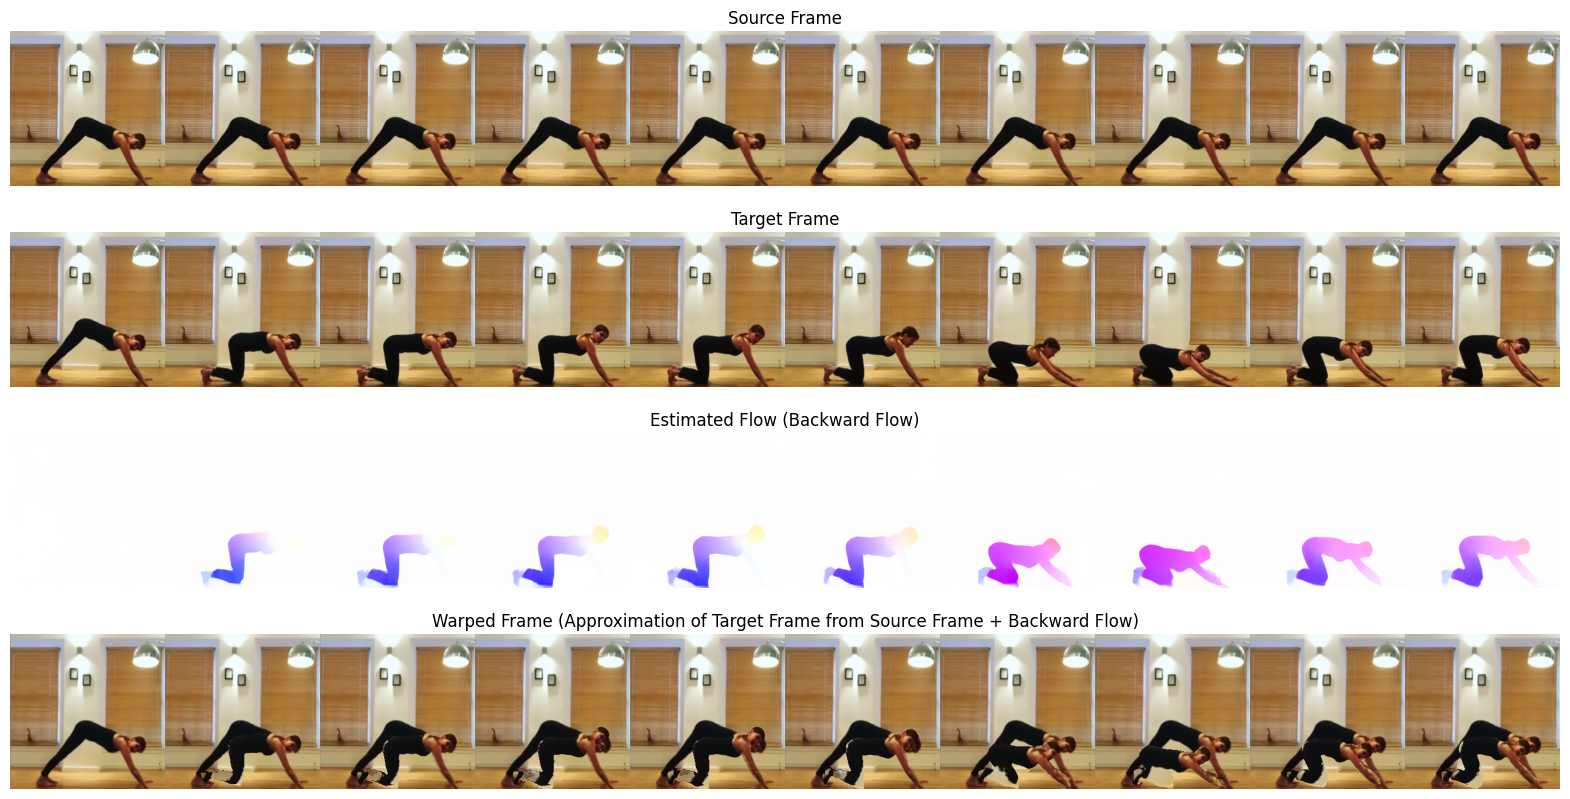

In [8]:
@torch.no_grad()
def est_flow_and_warp(source, target):
    """Estimate optical flow (backward) and warp source to target using RAFT.

    Args:
        source (torch.Tensor): source image tensor of shape (B, C, H, W)
        target (torch.Tensor): target image tensor of shape (B, C, H, W)

    Returns:
        tuple: (warped source tensor of shape (B, C, H, W), backward flow tensor of shape (B, 2, H, W))
    """
    assert source.size() == target.size(), f"Source and target images must have the same shape."

    # TODO Student: Estimate optical flow
    # Important: backward flow is estimated from target to source
    # We need this to be able to warp the source image to the target image without ambiguities
    flow = raft(target, source)[-1]

    B, C, H, W = source.shape

    grid = torch.stack(torch.meshgrid(torch.arange(W, device=device), torch.arange(H, device=device), indexing="xy"), dim=-1).float()[
        None
    ]
    grid_shifted = grid + rearrange(flow, "b c h w -> b h w c")
    warped = F.grid_sample(
        source,
        # grid_sample wants coords in [-1, 1]^2
        (grid_shifted / rearrange(torch.tensor([W / 2, H / 2], device=device), "c -> 1 1 1 c")) - 1,
        align_corners=False,
        mode="bilinear",
    )
    # END Student

    return warped, flow


# Estimate flow from starting frame to every 30th frame
frameskip = 30
source = seq[:1].repeat(int(math.ceil(seq.size(0) / frameskip)), 1, 1, 1)
target = seq[::frameskip].clone()
warped, flow = est_flow_and_warp(source, target)

# Visualize the results
plt.figure(figsize=(20, 10))

plt.subplot(4, 1, 1)
plt.title("Source Frame")
plt.imshow((rearrange(source.cpu().numpy(), "t c h w -> h (t w) c") + 1) / 2)
plt.axis("off")

plt.subplot(4, 1, 2)
plt.title("Target Frame")
plt.imshow((rearrange(target.cpu().numpy(), "t c h w -> h (t w) c") + 1) / 2)
plt.axis("off")

plt.subplot(4, 1, 3)
plt.title("Estimated Flow (Backward Flow)")
plt.imshow(rearrange(flow_to_image(flow).cpu().numpy(), "t c h w -> h (t w) c") / 255.0)
plt.axis("off")

plt.subplot(4, 1, 4)
plt.title("Warped Frame (Approximation of Target Frame from Source Frame + Backward Flow)")
plt.imshow((rearrange(warped.cpu().numpy(), "t c h w -> h (t w) c") + 1) / 2)
plt.axis("off")

plt.show()

---
**Which artifacts can you see? Try to explain what caused them.**

Generally, the warping based on the estimated flow works well. However, in the places where the person occludes the background in the source frame and does not in the target frame, the warping is unable to fill them in. This is caused by the fact that we know where the person moved, but in places that were previously occluded and did not move, the information just is not available in the source frame. The flow estimation model estimates zero motion there due to its prior world understanding, but there is no exact correspondence visible, and thus no correct warping possible.

---